In [16]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import torchvision.models as models

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

from sklearn.metrics import confusion_matrix, classification_report
#All necessary imports

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
! unzip -o /content/drive/MyDrive/datasets/pneumonia/test_pneumonia.zip
! unzip -o  /content/drive/MyDrive/datasets/pneumonia/train_pneumonia.zip
! cp /content/drive/MyDrive/datasets/pneumonia/best_model.pt .

Streaming output truncated to the last 5000 lines.
  inflating: train/pneumonia/6.jpeg  
  inflating: train/pneumonia/83.jpeg  
  inflating: train/pneumonia/86.jpeg  
  inflating: train/pneumonia/89.jpeg  
  inflating: train/pneumonia/128.jpeg  
  inflating: train/pneumonia/129.jpeg  
  inflating: train/pneumonia/176.jpeg  
  inflating: train/pneumonia/262.jpeg  
  inflating: train/pneumonia/294.jpeg  
  inflating: train/pneumonia/319.jpeg  
  inflating: train/pneumonia/328.jpeg  
  inflating: train/pneumonia/336.jpeg  
  inflating: train/pneumonia/360.jpeg  
  inflating: train/pneumonia/393.jpeg  
  inflating: train/pneumonia/443.jpeg  
  inflating: train/pneumonia/471.jpeg  
  inflating: train/pneumonia/521.jpeg  
  inflating: train/pneumonia/544.jpeg  
  inflating: train/pneumonia/549.jpeg  
  inflating: train/pneumonia/554.jpeg  
  inflating: train/pneumonia/557.jpeg  
  inflating: train/pneumonia/622.jpeg  
  inflating: train/pneumonia/632.jpeg  
  inflating: train/pneumonia/639.j

In [19]:
!ls

best_model.pt  drive  sample_data  test  train


## PUT PATHS TO DATA

In [20]:
data_dir = '.' # path to folder structured as train, test, val
data_dir_test="./test"
classes = os.listdir(data_dir+'/train/')
# print("class names : ",classes)
_0 = os.listdir(data_dir+ "/train/normal")
_1 = os.listdir(data_dir+ "/train/pneumonia")
print('total images for trainig:', len(_0)+len(_1))


total images for trainig: 10000


In [21]:
transform=transforms.Compose([transforms.Resize(128),
                                            transforms.CenterCrop(128),
                                            transforms.RandomRotation(5),
                                            transforms.RandomGrayscale(),
                                            transforms.RandomAffine(translate=(0.03,0.03), degrees=0),
                                            transforms.ToTensor(),
#                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std= [0.229, 0.224, 0.225])
                              ])
no_aug=transforms.Compose([transforms.Resize(128),
                                            transforms.CenterCrop(128),
                                            transforms.ToTensor(),
#                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std= [0.229, 0.224, 0.225])
                              ])
dataset_train = torchvision.datasets.ImageFolder(data_dir+'/train/',
                      transform=transform)
dataset_val = torchvision.datasets.ImageFolder(data_dir_test, # test data used for validation of model
                      transform=no_aug)


In [22]:
batch_size=32
num_workers=8
train_dloader = DataLoader(dataset_train, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dloader = DataLoader(dataset_val, batch_size, num_workers=num_workers, pin_memory=True)
# test_dloader = DataLoader(dataset_test, batch_size, num_workers=num_workers, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


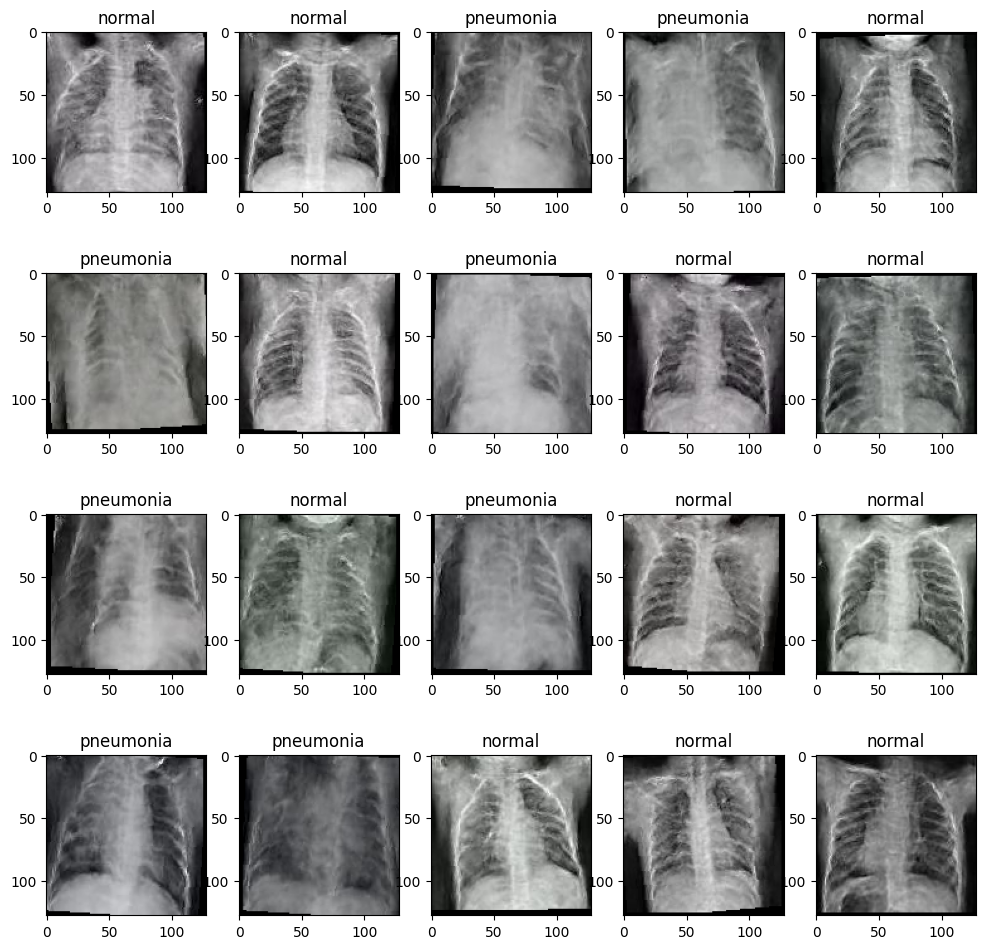

In [23]:
_, axs = plt.subplots(4,5, figsize=(12, 12))
axs = axs.flatten()
for x in train_dloader:
    break
for img, ax,label in zip(x[0][:20], axs,x[1][:20]):
    ax.set_title(dataset_train.classes[label.item()])
    ax.imshow(img.permute(1,2,0).numpy())
plt.show()

In [24]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],std= [0.229, 0.224, 0.225]) # normalisation (channelwise)
        self.network = models.resnet18(pretrained=True)
#         for param in self.network.parameters():
#             param.requires_grad = False
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier

    def forward(self, x):
        return self.network(self.norm(x))




In [25]:


# fn to find batch accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

# fn to average epoch loss and accuracy
def res(loss,acc):
    epoch_loss = np.mean([x for x in loss] )
    epoch_acc = np.mean([x for x in acc])
    return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}



In [26]:


def fit(epochs, model, train_data, val_data, weight, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # release all the GPU memory cache

    all_parms=[x for x in model.network.parameters()]
    optimizer = opt_func([{'params': all_parms[:-2], 'lr': 0.00001}, # remainig resnet18
                         {'params': all_parms[-2:], 'lr': 0.01}])   # last linear layer (weights + bias)
#     optimizer = torch.optim.SGD(model.network.fc.parameters(),lr=0.01,momentum=.9)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.97)
    best_f1 = 0

    for epoch in range(epochs):

        # Training Phase
        model.train()
        train_acc = []
        train_loss =[]
        val_acc=[]
        val_loss=[]
        lrs = []

        for images,labels in train_data:

            images,labels=images.to(device),labels.to(device)
            out = model(images)
            loss = F.cross_entropy(out, labels, weight=weight)
            acc,preds = accuracy(out, labels)

            train_acc.append(acc.item())
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()  # backpropagate error and compute gradient


            optimizer.step()



        train_results = res(train_loss,train_acc)

        prediction=[]
        label=[]
        # evaluation phase
        model.eval()
        with torch.no_grad():
            for images,labels in val_data:
                images,labels=images.to(device),labels.to(device)
                out = model(images)
                loss = F.cross_entropy(out, labels)
                acc,preds = accuracy(out, labels)
                val_acc.append(acc.item())
                val_loss.append(loss.item())
                prediction+=list(preds.cpu().numpy())
                label+=list(labels.cpu().numpy())

        print(classification_report(label,prediction))
        # get weighted average f1score
        f1score=classification_report(label,prediction,output_dict=True)['weighted avg']['f1-score']

        val_results = res(val_loss,val_acc)
        # for saving best model
        if f1score > best_f1 :
            best_f1 = f1score
            torch.save(model.state_dict(), 'best_model.pt')
        print("epoch",epoch+1)
        print("train_result", train_results)
        print("val_result",val_results)
        print("\n\n")

    print("best f1score :",best_f1)


In [27]:

#model=Model().to(device)
#opt_func = torch.optim.Adam
#opt_func = torch.optim.SGD
#weights_for_classimbalance=torch.tensor([0.5,0.5]).to(device)
#fit(60,model,train_dloader,val_dloader,weights_for_classimbalance,opt_func =opt_func)

## Best Model

In [28]:
model=Model().to(device)
model.load_state_dict(torch.load('best_model.pt'))#.to_(device)
prediction=[]
label=[]
model.eval()
with torch.no_grad():
    for images,labels in val_dloader:
        images,labels=images.to(device),labels.to(device)
        out = model(images)
        loss = F.cross_entropy(out, labels)
        acc,preds = accuracy(out, labels)
        prediction+=list(preds.cpu().numpy())
        label+=list(labels.cpu().numpy())
print(classification_report(label,prediction))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


              precision    recall  f1-score   support

           0       0.79      0.89      0.83       161
           1       0.93      0.87      0.90       290

    accuracy                           0.87       451
   macro avg       0.86      0.88      0.87       451
weighted avg       0.88      0.87      0.88       451

